In [6]:
# !pip install xgboost
# !pip install lightgbm

In [18]:
# Packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [2]:
df = pd.read_csv('/workspaces/IDS721_FInal_Team_Project_SP23_Du_Wang/00_source_data/heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


### Data Preprocessing

In [8]:
X = df.drop('HeartDisease', axis=1)
# encode Yes and No to 1 and 0
X = X.replace({'Yes': 1, 'No': 0})
# encode categorical variables into one-hot encoding
X = pd.get_dummies(X)
y = df['HeartDisease']
y = y.replace({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8886)


In [9]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(xgb.score(X_test, y_test)))

Accuracy of XGBoost classifier on test set: 0.91


In [20]:
# check the feature importance
xgb.feature_importances_

array([0.00345136, 0.01764946, 0.00464227, 0.04643323, 0.00491967,
       0.00364248, 0.10765817, 0.00324037, 0.00340417, 0.00553029,
       0.02208441, 0.01058598, 0.02103482, 0.        , 0.07287716,
       0.05507043, 0.05423883, 0.05071912, 0.03037118, 0.01905202,
       0.01017569, 0.00583917, 0.00471414, 0.01685821, 0.035248  ,
       0.04133091, 0.04494524, 0.00431339, 0.00393456, 0.00454972,
       0.00435382, 0.0041357 , 0.01053855, 0.0057898 , 0.06145472,
       0.00321392, 0.00372566, 0.07741807, 0.0243981 , 0.01852215,
       0.0320337 , 0.04590128], dtype=float32)

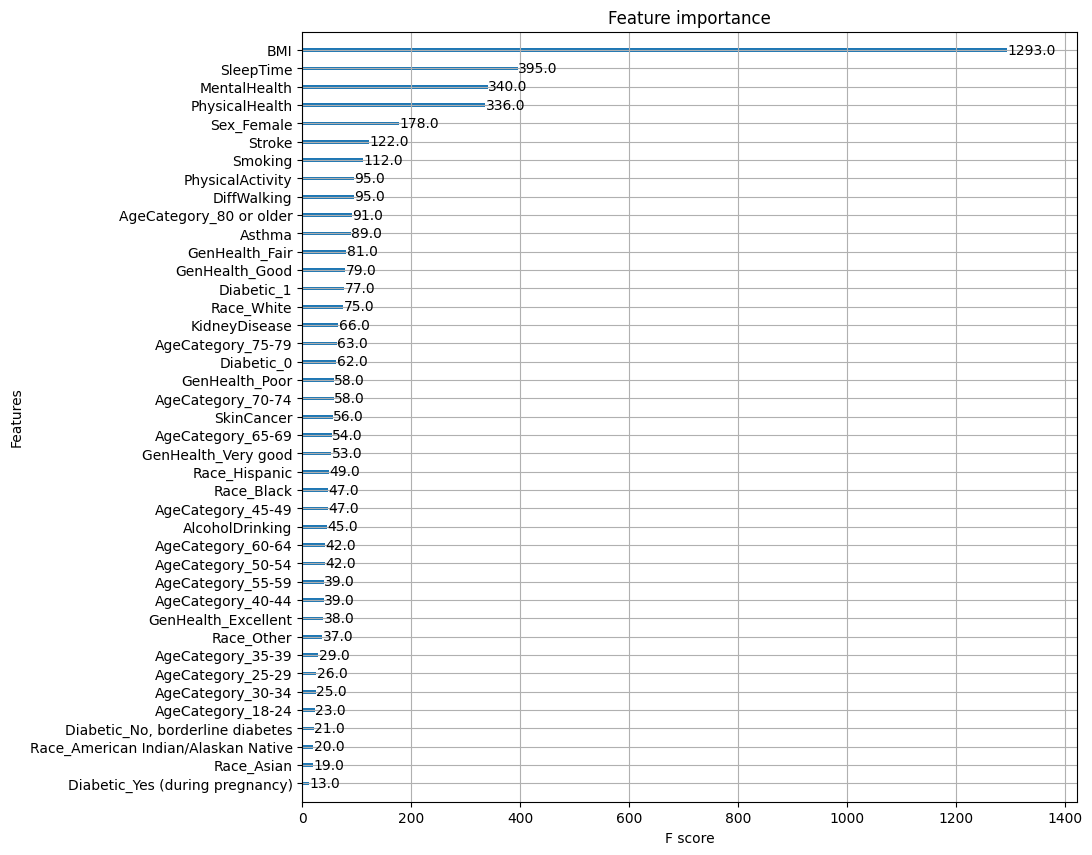

In [26]:
# plot the feature importance
from xgboost import plot_importance
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [10, 10]
plot_importance(xgb)
pyplot.show()

# save the plot into 20_intermediate_files
# pyplot.savefig('/workspaces/IDS721_FInal_Team_Project_SP23_Du_Wang/20_intermediate_files/feature_importance.png')